In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet
import xgboost as xgb

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import ks_2samp

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [4]:
# upload train dataframe
path = "../../data-256/"
train_df_allsamples = pd.read_csv(path+"train.csv")
train_df_allsamples.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [5]:
# upload train dataframe
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


# TFRecord describes stratified k-fold to keep counts of patient replicates evenly distributed within each fold

Some patients have as many as 115 images - to keep validation more representative of a real testing scenario, training and validation should not share images from the same patient. Furthermore, the number of replicates from each patient should be similar in each fold. The tfrecord column in the data table provides a k-fold partitioning scheme that keeps replicates even distributed in each fold. 

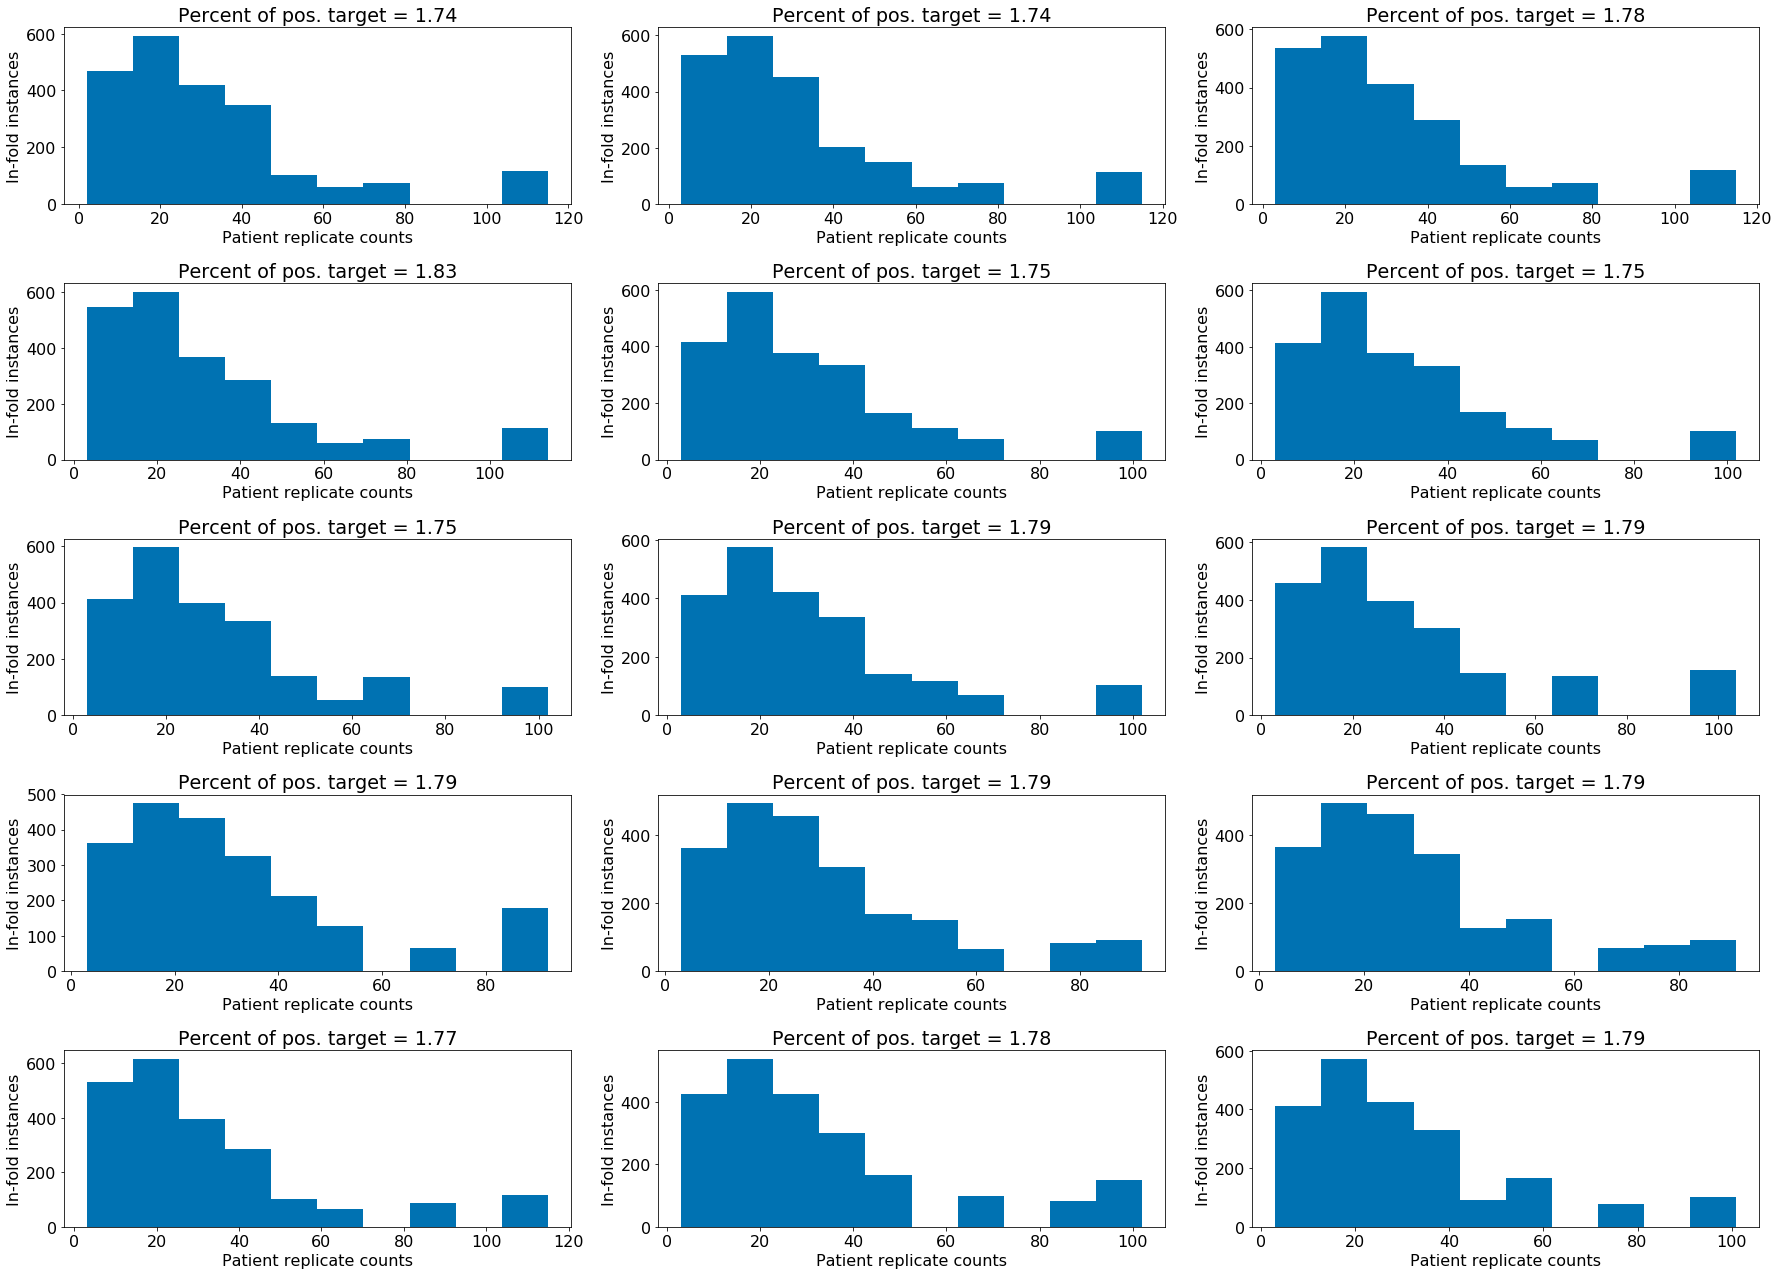

In [6]:
unique_patient_ids, patient_counts = np.unique(train_df_allsamples['patient_id'].values, return_counts=True)
patient_to_count = {p_id:count for p_id, count in zip(unique_patient_ids, patient_counts)}

tfrecords = train_df_allsamples['tfrecord'].values 
folds = np.arange(15)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16,
                     'legend.framealpha':.5,
                     'legend.edgecolor':'k',
                     'axes.edgecolor':'k'})
plt.figure(figsize=(5*5, 6*3))
k = 1 
for f in folds:
    fold_df = train_df_allsamples.iloc[tfrecords == folds[f], :]

    fold_patient_ids = fold_df['patient_id'].values 
    fold_patient_counts = [patient_to_count[p] for p in fold_patient_ids]
    fold_target = fold_df['target'].values
    fold_p_target = 100 * sum(fold_target) / len(fold_target)

    plt.subplot(5, 3, k)
    k += 1
    plt.hist(fold_patient_counts)
    plt.xlabel("Patient replicate counts")
    plt.ylabel("In-fold instances")
    plt.title("Percent of pos. target = {:.2f}".format(fold_p_target))
    
plt.tight_layout()
plt.show()

In [7]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df_allsamples[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform for all images 
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=8),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.ToTensor()])

# additional transform to augment positive samples 
transform_augment_h = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor()])
transform_augment_v = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor()])

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.ToTensor()])  

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform) 
        img_processed = transform_basic(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

In [8]:
# First, load the EfficientNet with pre-trained parameters 
ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=1024)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.LeakyReLU(),
                                    nn.Linear(1024, 1),
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

Loaded pretrained weights for efficientnet-b0


In [10]:
# Train the model
# Use the prebuilt data loader.
train_path = path + "train/"
test_path = path + "test/"

# define batch size and accumulation steps 
batchsize  = 10

# update folds to 5 sets of inds 
fold_set = [0, 1, 2]
    
# pull the training and validation data for each fold
inds = np.in1d(tfrecords, np.array(fold_set))
train_df = train_df_allsamples.iloc[~inds, :]
val_df = train_df_allsamples.iloc[inds, :]

# evaluate performance on validation data 
train_dataset = ValidDataset(train_df, train_path)                                              
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=False) 

# evaluate performance on validation data 
valid_dataset = ValidDataset(val_df, train_path)                                              
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batchsize, shuffle=False) 

# load model 
model = MyENet(ENet).to(device)
model.load_state_dict(torch.load('../Models/model_1.ckpt'))
    
# at the end of fold, use model to create new training data set 
model.eval()

print("Creating training data for xgb model")
X_train = []
y_train = []
for i, (images, meta_data, labels) in enumerate(train_loader):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, nn_pred), axis=1)

    # append the dataset
    X_train.append(batch_features)
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
    
print("Creating validation data for xgb model")
X_valid = []
y_valid = []
for i, (images, meta_data, labels) in enumerate(valid_loader):
    images = images.to(device)

    # Forward pass
    embed = model.embedding(images)
    nn_pred = model.output(embed).detach().cpu().numpy()
    embedding = embed.detach().cpu().numpy()

    # determine NN features for the set of images 
    batch_features = np.concatenate((embedding, nn_pred), axis=1)

    # append the dataset
    X_valid.append(batch_features)
    y_valid.append(labels.numpy())

X_valid = np.concatenate(X_valid, axis=0)
y_valid = np.concatenate(y_valid, axis=0) 

# rescale nn predictions by passing through inverse sigmoid function 
X_train[:, -1] = np.log(1 / X_train[:, -1] - 1)
X_valid[:, -1] = np.log(1 / X_valid[:, -1] - 1)

Creating training data for xgb model
Creating validation data for xgb model


In [11]:
def chunkIt(seq, num):
    avg = len(seq) / float(num)
    out = []
    last = 0.0

    while last < len(seq):
        out.append(seq[int(last):int(last + avg)])
        last += avg

    return out

def get_patient_splits(patient_ids, n_splits=3, n_bins=5):
    patients, counts = np.unique(patient_ids, return_counts=True) 
    counts_per_bin, bin_edges = np.histogram(counts, n_bins)
    
    # initialize empty set of patient splits 
    patient_splits = []
    for _ in range(n_splits):
        patient_splits.append([])
    
    for i in range(n_bins):
        patients_in_bin = patients[(counts>bin_edges[i]) & (counts<bin_edges[i+1])]
        patients_split = chunkIt(patients_in_bin, n_splits)
        
        for j, p_split in enumerate(patient_splits):
            p_split += list(patients_split[j])
            
    return patient_splits 

In [12]:
# create folds with similar distributions of patient counts and different patients 
patient_ids = train_df['patient_id'].values
patient_splits = get_patient_splits(patient_ids, n_splits=3, n_bins=5) 

In [13]:
# define function to fit and return xgboost model
def fit_xgboost(X_train, y_train, X_val, y_val):

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # booster params
    max_depth, lr, subsample, colsample, mcw, lmbda, scale, stop_rounds = [3, .05, .9, .8, .02, .07, 60, 21]
    param = {'max_depth':np.int(np.ceil(max_depth)),
            'learning_rate':lr,
            'subsample':subsample,
            'colsample_bytree':colsample, 
            'eval_metric':'auc',
            'lambda':lmbda,
            'min_child_weight':mcw,
            'scale_pos_weight':scale,
            'objective': 'binary:logistic',
            'silent':1,
            'nthread': 8}

    # specify validation set
    evallist = [(dval, 'eval')]

    # Training
    num_round = 3000
    bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=stop_rounds)

    return bst

In [18]:
# define "out of fold" set of predictions, represents validation performance
oof = np.zeros(len(X_train))
predictions = np.zeros(len(X_valid))

for i, patient_split in enumerate(patient_splits):
    
    # get train and val indeces 
    val_index = np.in1d(patient_ids, patient_split)
    
    # get data partitions for Xtrain and Xval
    X_tr, X_vl = X_train[~val_index, :-1], X_train[val_index, :-1]
    y_tr, y_vl = y_train[~val_index], y_train[val_index]

    # train xgboost
    bst = fit_xgboost(X_tr, y_tr, X_vl, y_vl)

    # save out of fold predictions
    yprob = bst.predict(xgb.DMatrix(X_vl))
    oof[val_index] += yprob
    
    # make predictions on held-out data 
    predictions += bst.predict(xgb.DMatrix(X_valid[:, :-1])) / len(patient_splits)

[0]	eval-auc:0.908684
Will train until eval-auc hasn't improved in 30 rounds.
[1]	eval-auc:0.917608
[2]	eval-auc:0.927332
[3]	eval-auc:0.934543
[4]	eval-auc:0.939495
[5]	eval-auc:0.939825
[6]	eval-auc:0.940173
[7]	eval-auc:0.941123
[8]	eval-auc:0.941405
[9]	eval-auc:0.942041
[10]	eval-auc:0.942855
[11]	eval-auc:0.944927
[12]	eval-auc:0.945587
[13]	eval-auc:0.945706
[14]	eval-auc:0.94855
[15]	eval-auc:0.94871
[16]	eval-auc:0.948493
[17]	eval-auc:0.948667
[18]	eval-auc:0.949216
[19]	eval-auc:0.949432
[20]	eval-auc:0.949215
[21]	eval-auc:0.948905
[22]	eval-auc:0.951441
[23]	eval-auc:0.951982
[24]	eval-auc:0.95212
[25]	eval-auc:0.951847
[26]	eval-auc:0.952086
[27]	eval-auc:0.952125
[28]	eval-auc:0.953091
[29]	eval-auc:0.952811
[30]	eval-auc:0.953131
[31]	eval-auc:0.953284
[32]	eval-auc:0.953076
[33]	eval-auc:0.95078
[34]	eval-auc:0.95165
[35]	eval-auc:0.952141
[36]	eval-auc:0.952261
[37]	eval-auc:0.951851
[38]	eval-auc:0.951779
[39]	eval-auc:0.951494
[40]	eval-auc:0.951248
[41]	eval-auc:0.

[61]	eval-auc:0.962396
[62]	eval-auc:0.962302
[63]	eval-auc:0.962434
[64]	eval-auc:0.962213
[65]	eval-auc:0.962253
[66]	eval-auc:0.962262
[67]	eval-auc:0.962477
[68]	eval-auc:0.962343
[69]	eval-auc:0.962324
[70]	eval-auc:0.962056
[71]	eval-auc:0.961968
[72]	eval-auc:0.96204
[73]	eval-auc:0.962075
[74]	eval-auc:0.962119
[75]	eval-auc:0.962366
[76]	eval-auc:0.962426
[77]	eval-auc:0.96261
[78]	eval-auc:0.96263
[79]	eval-auc:0.962691
[80]	eval-auc:0.962879
[81]	eval-auc:0.962532
[82]	eval-auc:0.962502
[83]	eval-auc:0.962443
[84]	eval-auc:0.962482
[85]	eval-auc:0.962463
[86]	eval-auc:0.962269
[87]	eval-auc:0.962224
[88]	eval-auc:0.962146
[89]	eval-auc:0.96214
[90]	eval-auc:0.962128
[91]	eval-auc:0.962303
[92]	eval-auc:0.962282
[93]	eval-auc:0.962211
[94]	eval-auc:0.962378
[95]	eval-auc:0.96227
[96]	eval-auc:0.962273
[97]	eval-auc:0.962368
[98]	eval-auc:0.962279
[99]	eval-auc:0.962256
[100]	eval-auc:0.962364
[101]	eval-auc:0.962456
[102]	eval-auc:0.962286
[103]	eval-auc:0.962328
[104]	eval-a

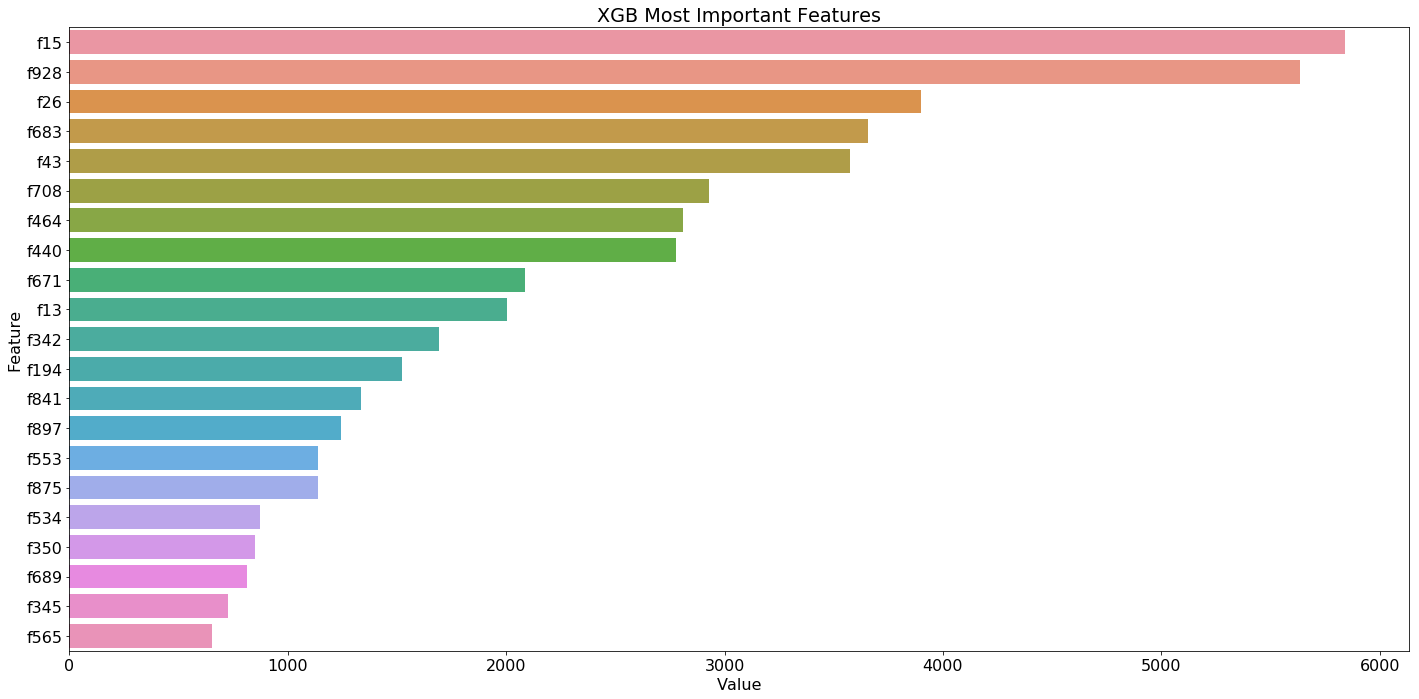

In [19]:
import seaborn as sns

bst_feature_dict = bst.get_score(importance_type='gain')
feature_names = list(bst_feature_dict.keys())
feature_importance = [bst_feature_dict[key] for key in feature_names]

feature_imp = pd.DataFrame()
feature_imp['Feature'] = feature_names 
feature_imp['Value'] = feature_importance

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:21])
plt.title('XGB Most Important Features')
plt.tight_layout()
plt.show()

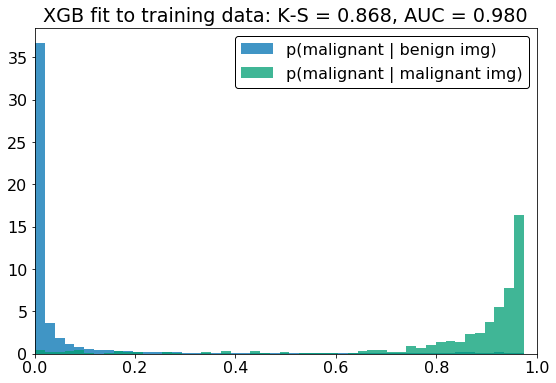

In [20]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

train_predictions = bst.predict(xgb.DMatrix(X_train[:, :-1]))

counts, bins = np.histogram(np.array(train_predictions), bins=50)
plt.hist(train_predictions[y_train==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(train_predictions[y_train==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(train_predictions[y_train==0], 
                           train_predictions[y_train==1])
fpr, tpr, _ = roc_curve(y_train, train_predictions)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("XGB fit to training data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

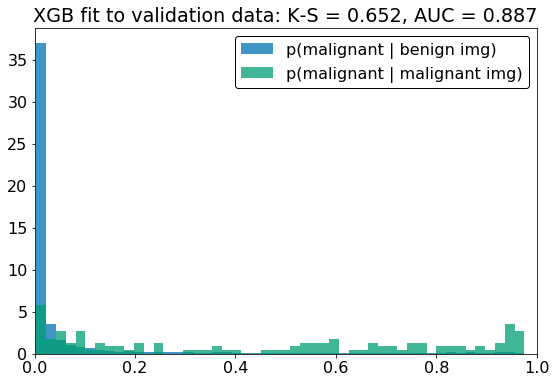

In [21]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

valid_pred = predictions

counts, bins = np.histogram(np.array(valid_pred), bins=50)
plt.hist(valid_pred[y_valid==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(valid_pred[y_valid==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(valid_pred[y_valid==0], 
                 valid_pred[y_valid==1])

fpr, tpr, _ = roc_curve(y_valid, valid_pred)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("XGB fit to validation data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()